<a href="https://colab.research.google.com/github/shivangi-gupta-01/Potato-Disease-Prediction/blob/main/Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [1]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2163 files belonging to 3 classes.


In [6]:
classes= dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

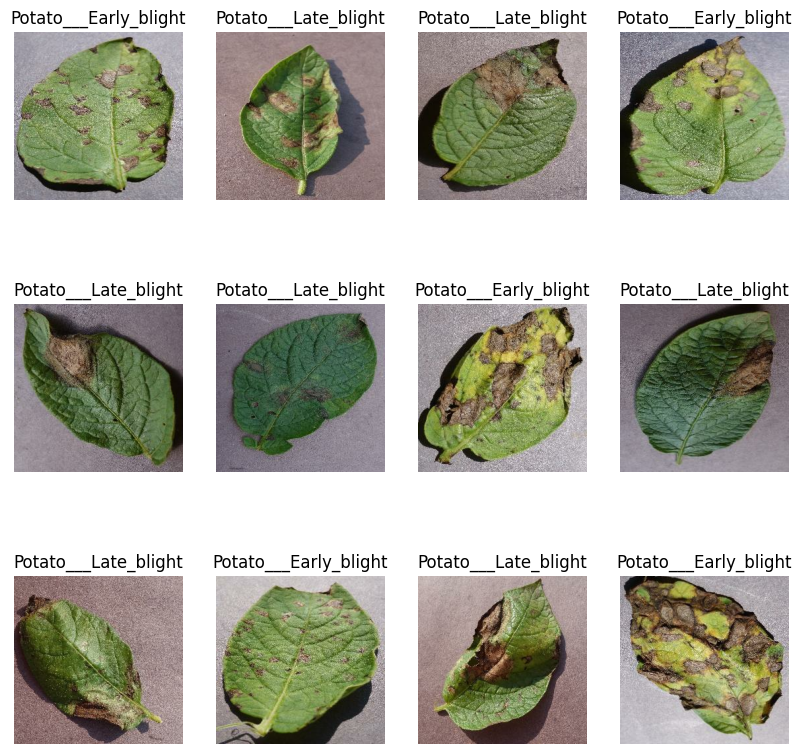

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range (12):
    ax= plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

In [15]:
len(dataset)

68

In [17]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [19]:
train_ds=dataset.take(54)
len(train_ds)

54

In [20]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [21]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [23]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [36]:
len(train_ds)

54

In [37]:
len(val_ds)

6

In [38]:
len(test_ds)

8

In [39]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [44]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])